# Fitting Thomson Scattering Spectrum

###Loading the data
First, you need to provide raw data in the form of a .asc file (plain ASCII, tab delimited) exported by Andor Solis for both the high power background and the shot. The background is used to calibrate the fibres. You can provide as many background files as you wish - the raw images are summed together. This is especially useful if you have pin scattering measurements for individual fibres, as the signal to noise ratio is far better than the high power background where the light scatters off particles in the vacuum chamber. To create a Thomson Scattering Analysis object, we use:

`ts=TsA.TS_Analysis('folder/shot_filename.asc',['folder/background_file1.asc','folder/background_file2.asc'])`

where the background files are separated by commas inside the square brackets. Data is stored in the folder TS_data and we have a naming convention, so usually we would type eg:

`ts=TS_Analysis('TS_data/s0605_15 shot.asc',['TS_data/s0605_15 full power test.asc'])`

`ts` is an object that knows about the data in the files. `ts` starts by asking you where the fibre edges are. A graph appears on the screen with two sliders labelled `spacing` and `offset`. `spacing` is the number of pixels per fibres and `offset` is where the first fibre begins. Move the sliders so that the red dots lie in between each fibre in the minima. The default settings work well for most shots - you usually only need to adjust `offset`. It is difficult to get the red dots perfect for every fibre, but this only amounts to an error of 1 pixel, so it is not significant.
###Splitting into fibres
Once we have told `ts` where the fibre edges are, it can split the background and shot images into fibres and average over the pixels that correspond to each fibre:

`ts.split_into_fibres()`
`ts.norm_zero_fibres()`
###Setting fibre bundle angles
At this point, we need to provide the angle that each fibre was at with respect to $k_{in}$. Say fibre bundle A was at 45' to $k_{in}$ and fibres 1A through 14A are on the spectrometer, and fibre bundle B was at 135' to $k_{in}$ and fibres 1B through 13B are on the spectrometer, then we'd set the angles like this:
`a_angle=[45]*14` 
`b_angle=[135]*13`
`ts.pair_fibres(a_angle+b_angle)`
###Pairing backgrounds with shot data
The last line pairs up the data from the background image with the data from the shot image in a `Fibre` object which knows about the appropriate angle. To get hold of a `Fibre` object, we can use

`f=ts.select_fibre(Fnum,Fset)`

For eg. fibre 7A, `Fnum=7` and `Fset='A'`.
###Plotting fibre data
Now we are ready to display data from the fibres using the functon plot_data:

`ts.plot_data(Fnum,Fset, tm=1.5)`

`ts` finds the right fibre object that represents the fibre specified by `Fnum` and `Fset` and displays the normalised data for the shot and the background. For ease of viewing, the background signal is multiplied by 1/2 so it doesn't overlap the shot signal. Using `ts.plot_data` you can quickly view data. 
*Note: The argument `tm=1.5` in `ts.plot_data` sets the size of the text in the plot. This is useful for making figures for papers*.
###Fitting routines
Now we can fit the data. Currently, two modes of fitting are supported:
1. Multi-ion-species fitting where all ion species have the same temperature and flow velocity, but different A, Z and fractional density.
2. Two-ion-species fitting where the two ion species can have different temperatures and flow velocities, as well as varying A, Z and fractional density.

*The reasons for this seemingly arbitrary distinction are enforced by the fitting library used - it is impossible to have an arbitrary number of free parameters in the fit, so we most specify either one or two ion temperatures/ion flow velocities*

Each parameter in the fit can be set to either independent or dependent. **Independent** variables are not altered by the fit. Their value must be set by the user. **Dependent** Variables are altered to produce the best fit possible. A guess at the initial value must be set by the user. Parameters in the fit are:

* 'n_e': Electron density in cm^-3, always **Independent**
* 'T_e': Electron temperature in electron volts.
* 'V_fe': Electron flow velocity in m/s. See note
* 'Aj':  List of nuclear masses of ion species in nucleon masses. Eg. for carbon, hydrogen and oxygen set to (12,1,16). Always **Independent**
* 'Zj':  List of ion effective charge, eg. (6,1,4). Position corresponds to ion species in Aj. Always **Independent**
* 'Fj':  List of fractional ion number density. For $CH_2$, set to (2,1) if Aj=(1,12). Only the ratio matters, so (0.5,1) also works! Always **Independent**.
* 'stry': Fraction of signal made up of stray light. Greater than 0, less than 1.
* 'amp': Fraction of signal made up of stray light. Greater than 0, less than 1.
 #####For the multi-species, single temperature model:
* 'model': 'multi species'
* Aj, Zj, Fj can contain as many species as you like, but all have to be the same length. For single ion species you must still use () and a comma eg. Aj=(28,).
* 'T_i1': Single ion temperature in electron volts.
* 'V_fi1':Single ion flow velocity in m/s. 
 #####For the two-species, two-temperature model:
* 'model': 'two stream'
* Aj, Zj and Fj must contain exactly two items.
* 'T_i1': Ion temperature for species 1 in electron volts.
* 'V_fi1': Ion flow velocity for species 1 in m/s. 
* 'T_i2': Ion temperature for species 2 in electron volts.
* 'V_fi2': Ion flow velocity for species 2 in m/s. 

*Note that species 1 is the first species in Aj, Zj, Fj, and species 2 is the second - position matters!*

###The electron flow velocity
Electrons do not have to move with ions, but they often do. A net flow of electrons with respect to ions results in an electric current, and an asymmetry of the ion acoustic peak heights in the collective scattering regime. The code always includes an electrons velocity equal to the average ion velocity in the plasma. For a two component plasma, this is:

`V_fe_average=(F1*V_fi1+F2*V_fi2)/(F1+F2)`

In addition to this, the code can include a variable that represents the drift of the electrons with respect to the average ion flow, and this is the paramter `V_fe`. Unless you can see asymmetry in the peaks of the ion acoustic wave function (see s0315_15) then it is best to set this to a **Independent** variable and set the value to 0.
###Response function
After the model has been evaluated for the given paramters, it is convolved with a Voigt profile which has been fit to the data in the background for the corresponding fibre. This accounts for any wavelength shift due to the fibre bundle being misaligned onto the spectrometer CCD. To achieve a better fit, it may be necessary to specify the width of the Voigt profile. A Voigt profile is the convolution of a Gaussian with a Lorentzian - the Gaussian has a width sigma, and the Lorentzian a width gamma. You can specify neither, either or both. If you're unhappy with the background fit, then specify gamma and sigma like this:

`Fnum=6
Fset='B'
f=ts.select_fibre(Fnum,Fset)
f.voigt_response(sigma=1.3e-11, gamma=1.6e-11)`
###Setting the plasma parameters
Parameters are stored in a 'dictionary', an object in python in which each entry has a key and a value. Here, the name of the variable is the key, and the value is a tuple (a list of numbers surrounded by parenthesis) in which the first item is the value of the variable, and the second item is the answer to the question 'Is this parameter independent?': and is written either `True` or `False`. An optional third paramter specifies the minimum value that a **Dependent** parameter can take during the fitting process. In practice, this is rarely necessary, but the stray light fraction `'stry'` might need it sometimes. As an example, here is on dictionary:

`plasma_parameters={ 'model': 'multi species',
                    'n_e': (3e18,True),#in cm^-3, must be specified
                    'T_e': (40, True),#In electron volts. 
                    'v_fe':(0, True),#m/s. Specify to constrain the fit, else None
                    'Aj':  ((28,28), True),#in nucleon masses, must be specified
                    'Zj':  ((4,4), True),#ion effective charge, must be specified
                    'Fj':  ((0.001,1), True),#fractional ion number density
                    'T_i1': (400, True),#In electron volts.
                    'V_fi1':(4e4, True),#m/s. 
NOT USED            'T_i2': (490, True),#In electron volts.
NOT USED            'V_fi2':(0, True),#m/s. 
                    'stry':(0.10, True), #Fraction of stray light to add.
                    'amp': (1.0, False) #Fraction of signal made up of spectrum.
                    }`

This example is for the multi-species model where the ion species all have the same temperature and flow velocity. We have a carbon-hydrogen plasma with a formula C2H, twice as much carbon as hydrogen. The electron temperature and flow velocity are **Dependent**. The ion flow velocity can be varied by the fit, but the ion temperature is fixed. The amount of stray light can be varied, but the amount cannot be less than 0. `T_i2` and `V_fi2` are specified, but are **not used** by the model

For the two-ion-species fit, you must specify the temperatures and velocities separately:

`plasma_parameters={ 'model': 'two species',
                    'n_e': (3e18,True),#in cm^-3, must be specified
                    'T_e': (40, True),#In electron volts. 
                    'v_fe':(0, True),#m/s. Specify to constrain the fit, else None
                    'Aj':  ((28,28), True),#in nucleon masses, must be specified
                    'Zj':  ((4,4), True),#ion effective charge, must be specified
                    'Fj':  ((2,2), True),#fractional ion number density
                    'T_i1': (400, True),#In electron volts.
                    'V_fi1':(4e4, True),#m/s. 
                    'T_i2': (400, True),#In electron volts.
                    'V_fi2':(-4e4, True),#m/s. 
                    'stry':(0.60, True), #Fraction of stray light to add.
                    'amp': (1.0, False) #Fraction of signal made up of spectrum.
                    }`

Here the two ion flows have equal speeds in opposite directions, with identical temperatures and fractional number densities. Because of the large amount of stray light we've fixed it at 0.6, after some experimentation by eye.
####Fully specified fits
If all parameters are set to `True`, or **Independent** then the fitting routine does not vary any parameters, but instead returns the model you have requested. This can be useful for getting your initial values close, and then incrementally allowing more values to be **Dependent**.
###Fitting routines
After you've written the correct dictionary for the fit you want to try, you must call one of the two fitting functions. First get the relevant fibre object:

`f=ts.select_fibre(Fnum,Fset)`

Then perform the fit using:

`f.fit_fibre(plasma_parameters)` 

The correct fitting routine (multi-species vs two-stream) is chosen based on the `'model'` parameter in `plasma_parameters`.
####Plotting
Call the pretty_plot function to get a pretty plot:

`ts.pretty_plot(Fnum,Fset, tm=1.5)`

The parameters used by the fit are printed in the grey box - you have to work out whether you or the fitting routine chose them.
####Fit report
The `lmfit` library used by the code is incredibly powerful. It produces a full report which you can read by calling:

`print f.skw_res.fit_report()`

The report includes number of iterations, confidence intervals (errors) on parameters and correlations between different parameters. It is most useful to read when the fit goes wrong, rather than when everything works.
####Exporting Data
To save the data from your fit, create a new cell (using '+' in the top left) and input:

`f.export_data(Fnum, Fset)`

Where `Fnum` and `Fset` are the fiber number and fibre set respectively. This produces a .dat file in Files that you can download by clicking the 'i' icon in the left-most column. The file has column headings for the wavelength shift in Angstroms, and the normalised background, ersponse, shot and fit to shot. It does not contain the fit parameters used.

To save your plot, use:

`ts.fig.savefig('Filename.png')`

Where filename is the something like the shot number, and you can use either .png or .pdf as a file ending to get the file in various formats.

In [1]:
%matplotlib inline
import ts_analysis as TsA

:0: FutureWarning: IPython widgets are experimental and may change in the future.


#s0315_15

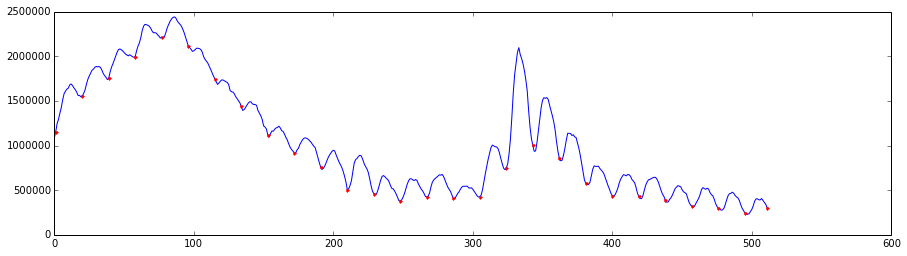

In [2]:
ts=TsA.TS_Analysis('TS_data/s0609_15 shot.asc',['TS_data/s0609_15 full power.asc'])

In [3]:
'''Split image into fibres'''
ts.split_into_fibres()
ts.norm_zero_fibres()
a_angle=[45]*14 #here we have fibres 1A through 14A at an angle of 45'
b_angle=[135]*13#and here we have fibres 1B through 13B at an angle of 135'
ts.pair_fibres(a_angle+b_angle)

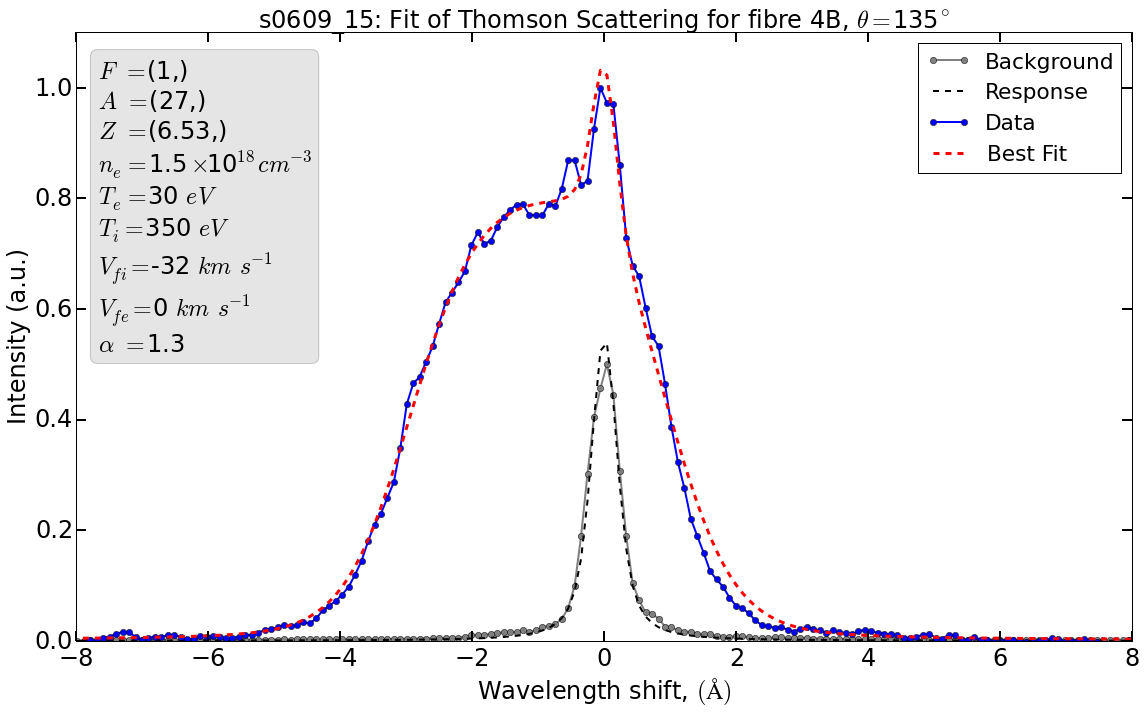

In [30]:
'''
Specify the plasma parameters in the form (Values, Minimum, Independent)
If Independent is True, then the value is fixed and minimum has no meaning
If Independent is False, then the value is an initial guess for the fit
and minimum is either a float, or None to specify no given minimum
For multi-species fits, Aj, Zj and Fj only can have their value as a tuple (A1,A2...Aj)
Even for a single-species fit, enclose A, Z and F in (), eg. 'Aj':((12), True, None)
'''
plasma_parameters={ 'model': 'multi species',
                    'n_e': (1.5e18,True),#in cm^-3, must be specified
                    'T_e': (30, True),#In electron volts. 
                    'V_fe':(0, True),#m/s. Specify to constrain the fit, else None
                    'Aj':  ((27,), True),#in nucleon masses, must be specified
                    'Zj':  ((6.53,), True),#ion effective charge, must be specified
                    'Fj':  ((1,), True),#fractional ion number density
                    'T_i1': (40, False),#In electron volts.
                    'V_fi1':(-2.0e4, False),#m/s.
                    'T_i2': (400, True),#In electron volts.
                    'V_fi2':(1e4, True),#m/s. 
                    'stry':(0.3, True), #Fraction of signal made up of stray light. >0, <1.0!!
                    'amp': (1.0, False) #Fraction of signal made up of spectrum.
                    }

'''Choose the fibre to fit'''
Fnum=4
Fset='B'
'''This code fits and plots the result'''
f=ts.select_fibre(Fnum,Fset)
f.voigt_response(gamma=1.41e-11, sigma=1.27e-11)
f.fit_fibre(plasma_parameters)
#print f.skw_res.fit_report()
ts.pretty_plot(Fnum,Fset, tm=1.2)

In [52]:
TsA.ZTe_finder(n_e=3e17,ZTe_experimental=4.5*10,Z_guess=5.4,element='Al') 

(3.6898279399999998, 13.0001)

In [32]:
for i in range(0,14):
    ts.plot_data(i, 'B')